# Setup

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [19]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 200)
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = (20, 3)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200 , 'figure.figsize': (10, 5)})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_style('darkgrid')

# Importing data

In [20]:
df = pd.read_excel(("DATA.xlsx"), sheet_name = None)
# INFLATION = df["INFLATION"].set_index("Date").resample("M", origin = df["INFLATION"]["Date"][0]).mean()
CPI = df["CPI"].set_index("Date").resample("M").mean()
CRUDE_OIL = df["CRUDE_OIL"].set_index("Date").resample("M").mean()
HOUSE = (df["HOUSE"].set_index("Date")/3).resample("M").mean().ffill()
ELECTRICITY = ((df["ELECTRICITY"].set_index("Date").iloc[:-1])/3).resample("M").mean().ffill()

In [21]:
df_red = pd.concat([CPI, CRUDE_OIL, HOUSE, ELECTRICITY], join = "inner", axis = 1)
# Transforming the data into inflation rate
df_red_transformed = df_red.diff().dropna().reset_index(drop = True).div(df_red.iloc[:-1].reset_index(drop = True)) * 100
df_red_transformed.index = df_red.index[:-1]
df_red_transformed.columns = ["Inflation", "Crude Oil prices difference", "House prices difference", "Electricity prices difference"]
df_red_transformed_train = df_red_transformed.iloc[:-12]
df_red_transformed_test = df_red_transformed.iloc[-12:]

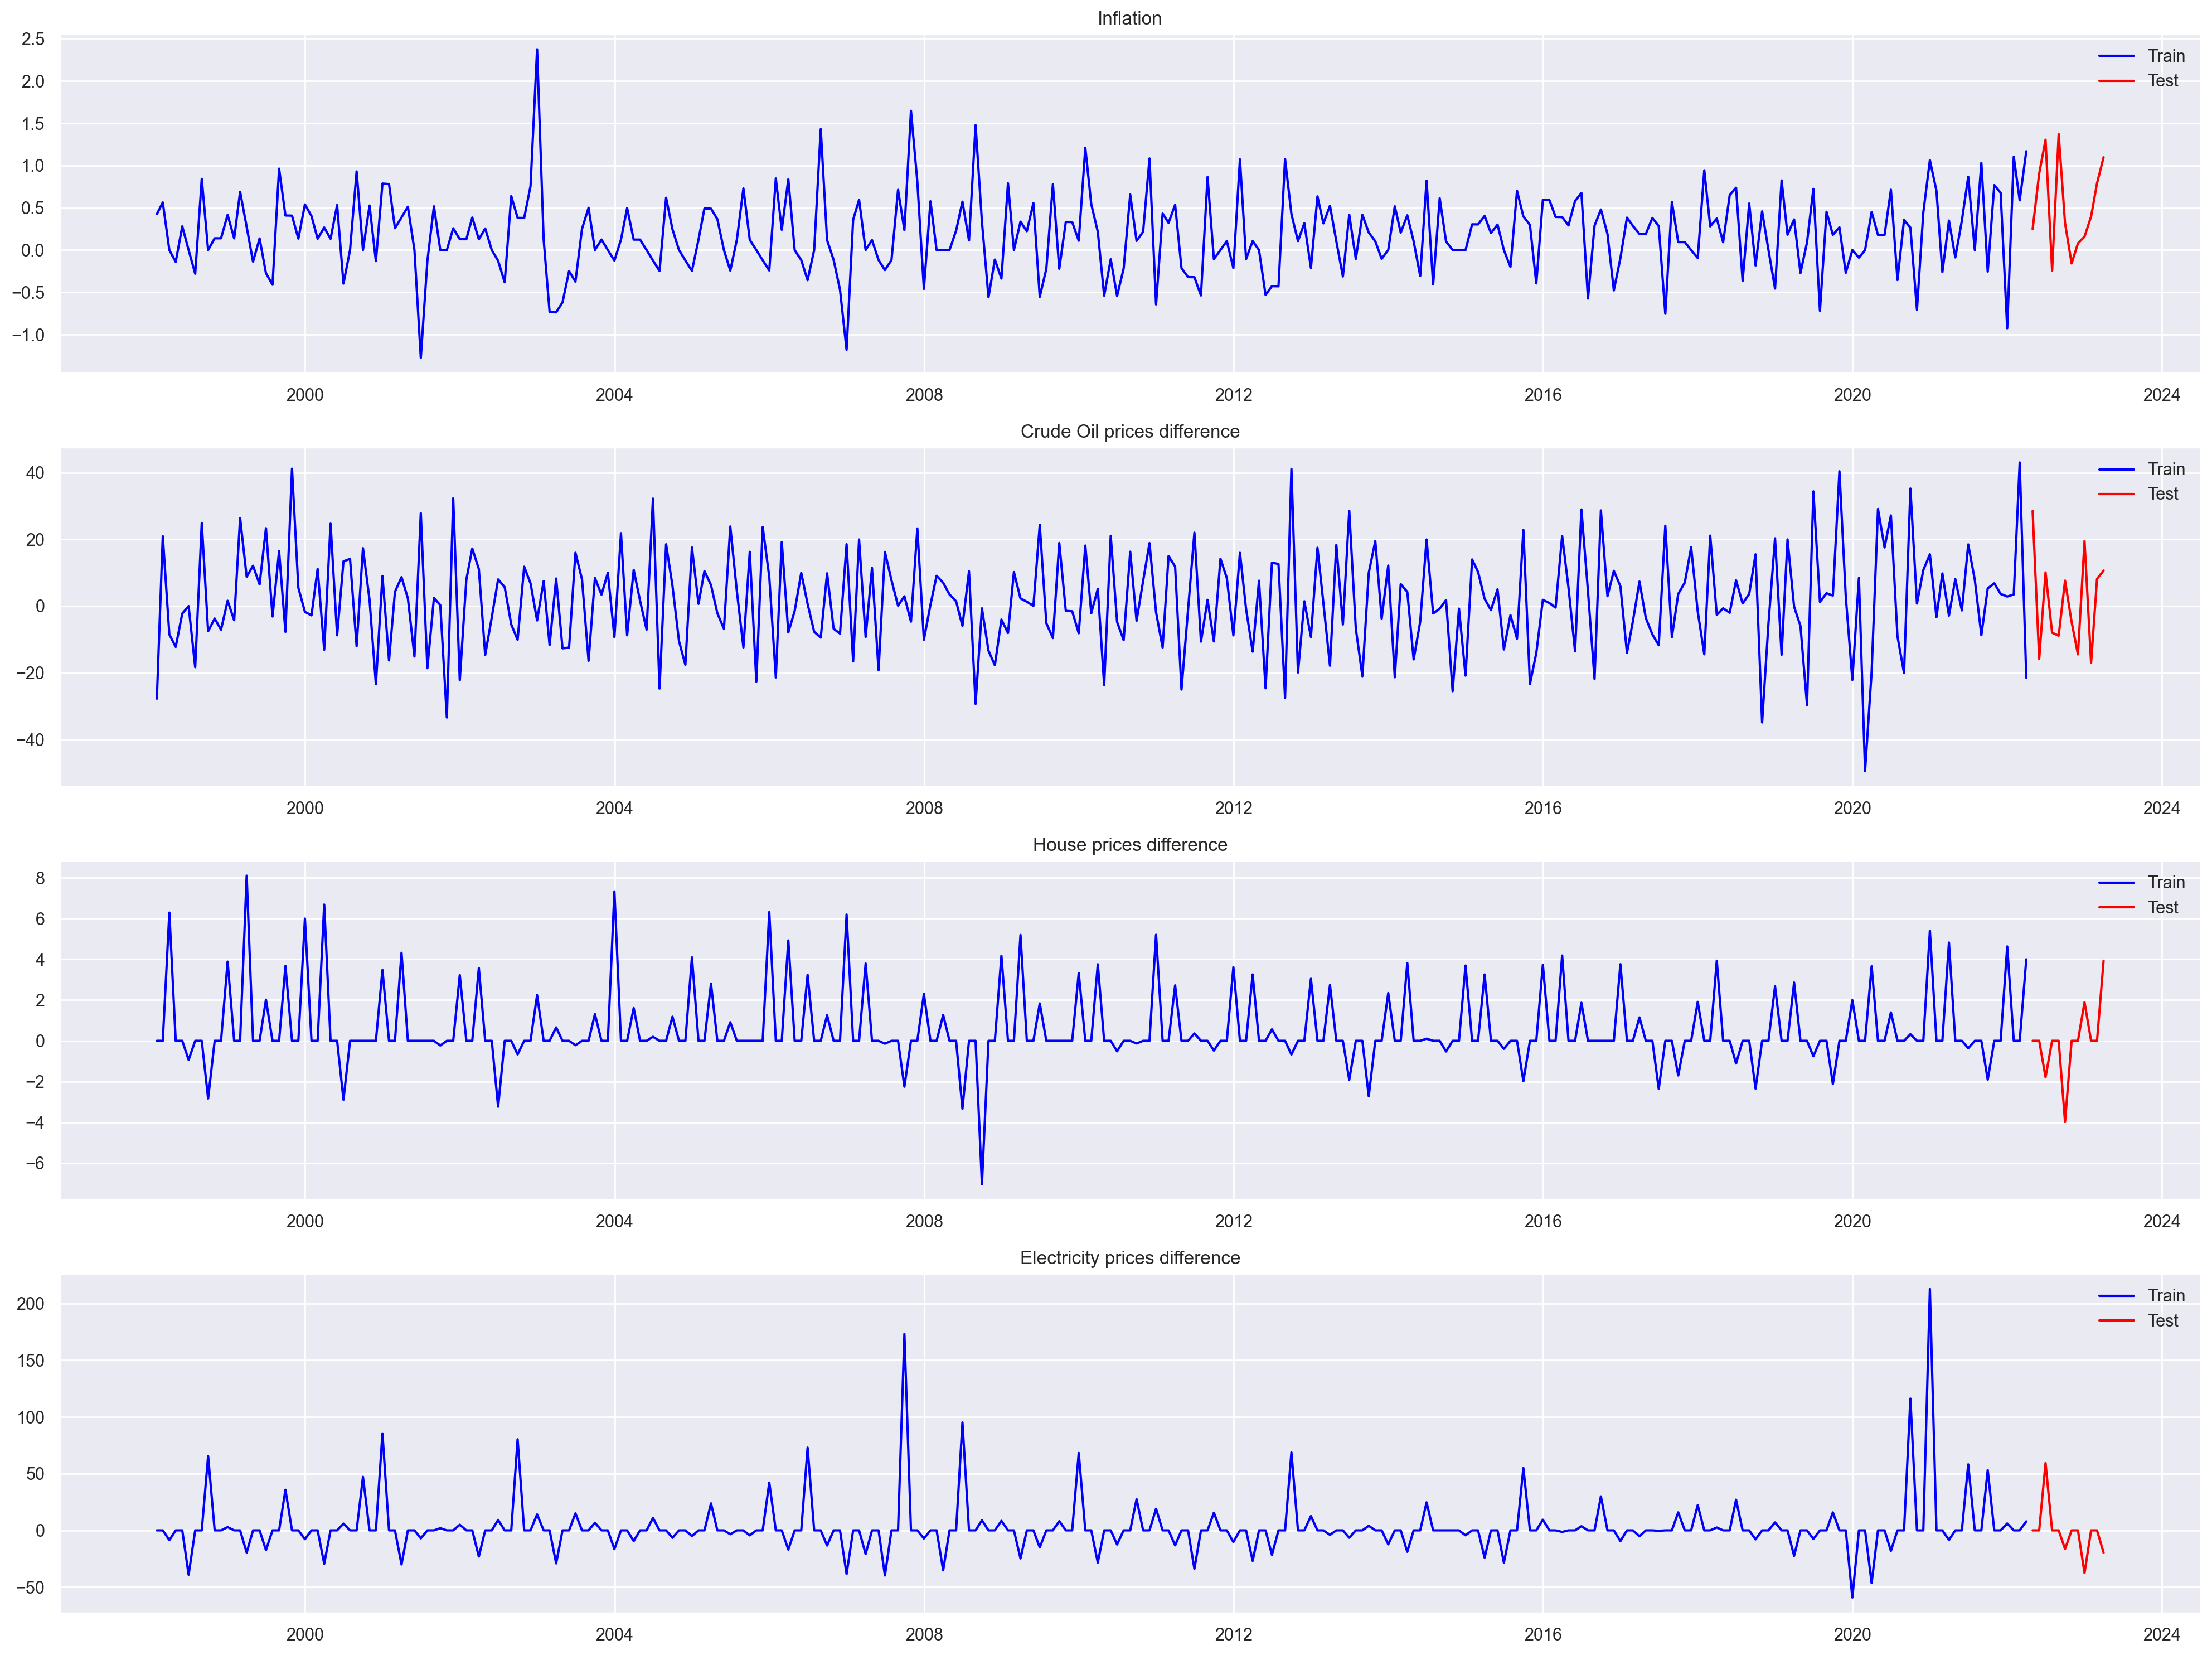

In [22]:
fig1, ax1 = plt.subplots(4, figsize = (20, 15))
for i in range(len(ax1)):
    ax1[i].plot(df_red_transformed_train.iloc[:, [i]], color = "blue", label = "Train")
    ax1[i].plot(df_red_transformed_test.iloc[:, [i]], color = "red", label = "Test")
    ax1[i].set_title(df_red_transformed.columns[i])
    ax1[i].legend()
plt.tight_layout()
plt.show()

In [23]:
# Function for calculating sample autocovariance
def autocovariance_fun(x, lag):
    x = x.iloc[:,0]
    autocovariance = np.array([])
    x_mean = x.mean()
    n = len(x)
    for i in range(lag+1):
        sum_ = np.array([])
        for j in range(n-i):
            sum_ = np.append(sum_, (x.iloc[j+i]-x_mean)*(x.iloc[j]-x_mean))
        autocovariance = np.append(autocovariance, sum_.sum()/n)
    return autocovariance

# Function for plotting ACF
def plt__acf(x, lag, title = None):
    if title == None:
        title = x.columns[0]
    acf = np.transpose(autocovariance_fun(x, lag)/(autocovariance_fun(x, lag)[0]))
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.vlines(range(lag+1), [0], acf, linewidth = 3)
    ax.plot(range(lag+1), acf, linestyle = "None", marker = "o", markersize = 5)
    ax.set_title(f"ACF plot for {title}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    plt.show()
    return acf

# Function for plotting PACF
def plt__pacf(x, lag, title = None):
    if title == None:
        title = x.columns[0]
    Gamma = np.zeros((lag, lag))
    acov = autocovariance_fun(df_red_transformed[["Inflation"]], lag)
    pacf = np.array([])
    pacf = np.append(pacf, 1)
    for i in range(lag):
        for j in range(lag):
            Gamma[i, j] = acov[np.abs(i-j)]
    for i in range(1,lag+1):
        pacf = np.append(pacf, (np.linalg.inv(Gamma[:i,:i]) @ acov[1:(i+1)])[-1])
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.vlines(range(lag+1), [0], pacf, linewidth = 3)
    ax.plot(range(lag+1), pacf, linestyle = "None", marker = "o", markersize = 5)
    ax.set_title(f"PACF plot for {title}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("PACF")
    plt.show()
    return pacf

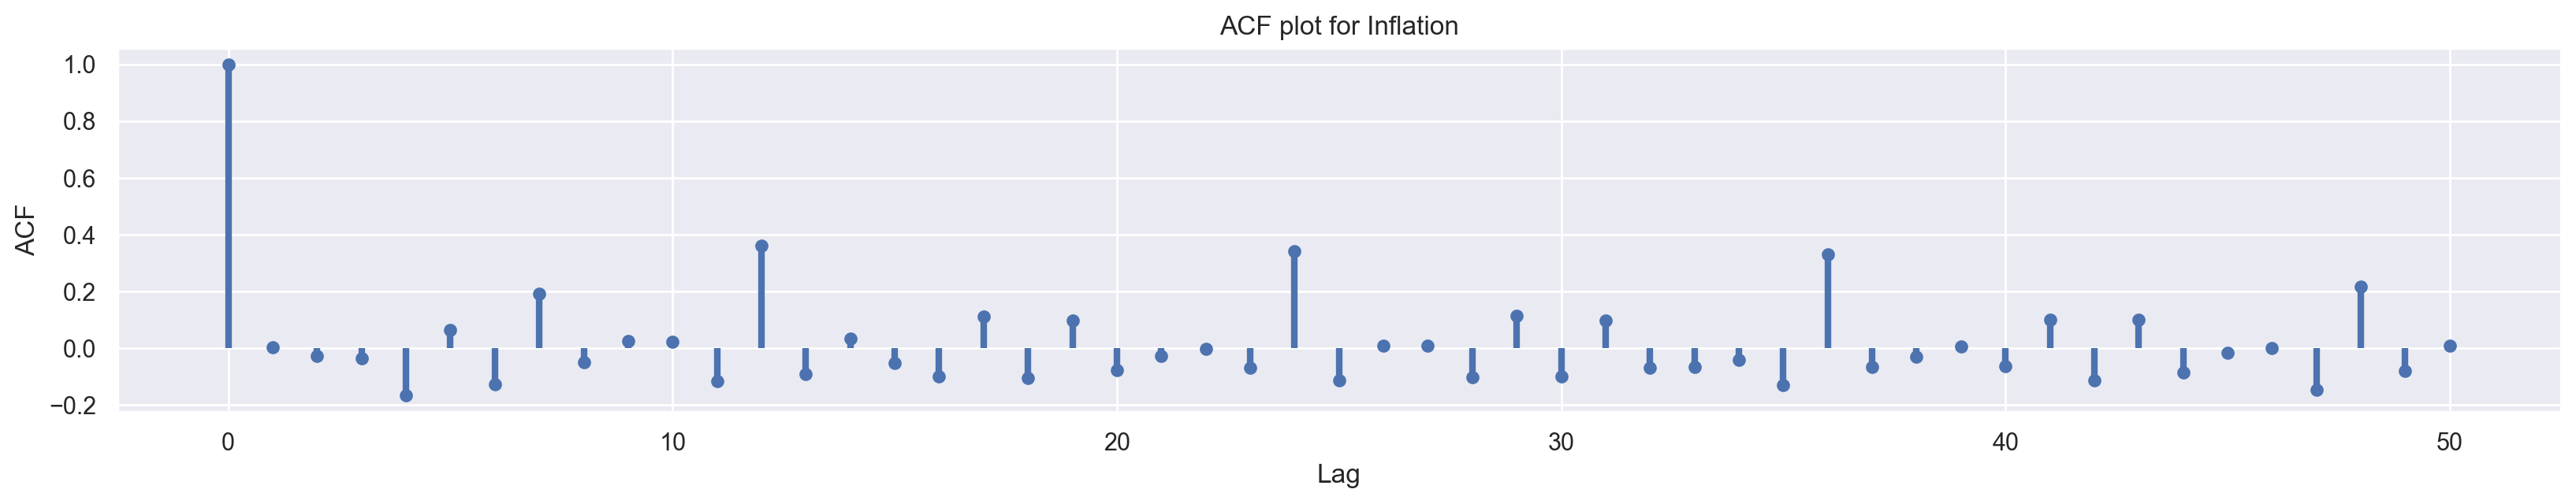

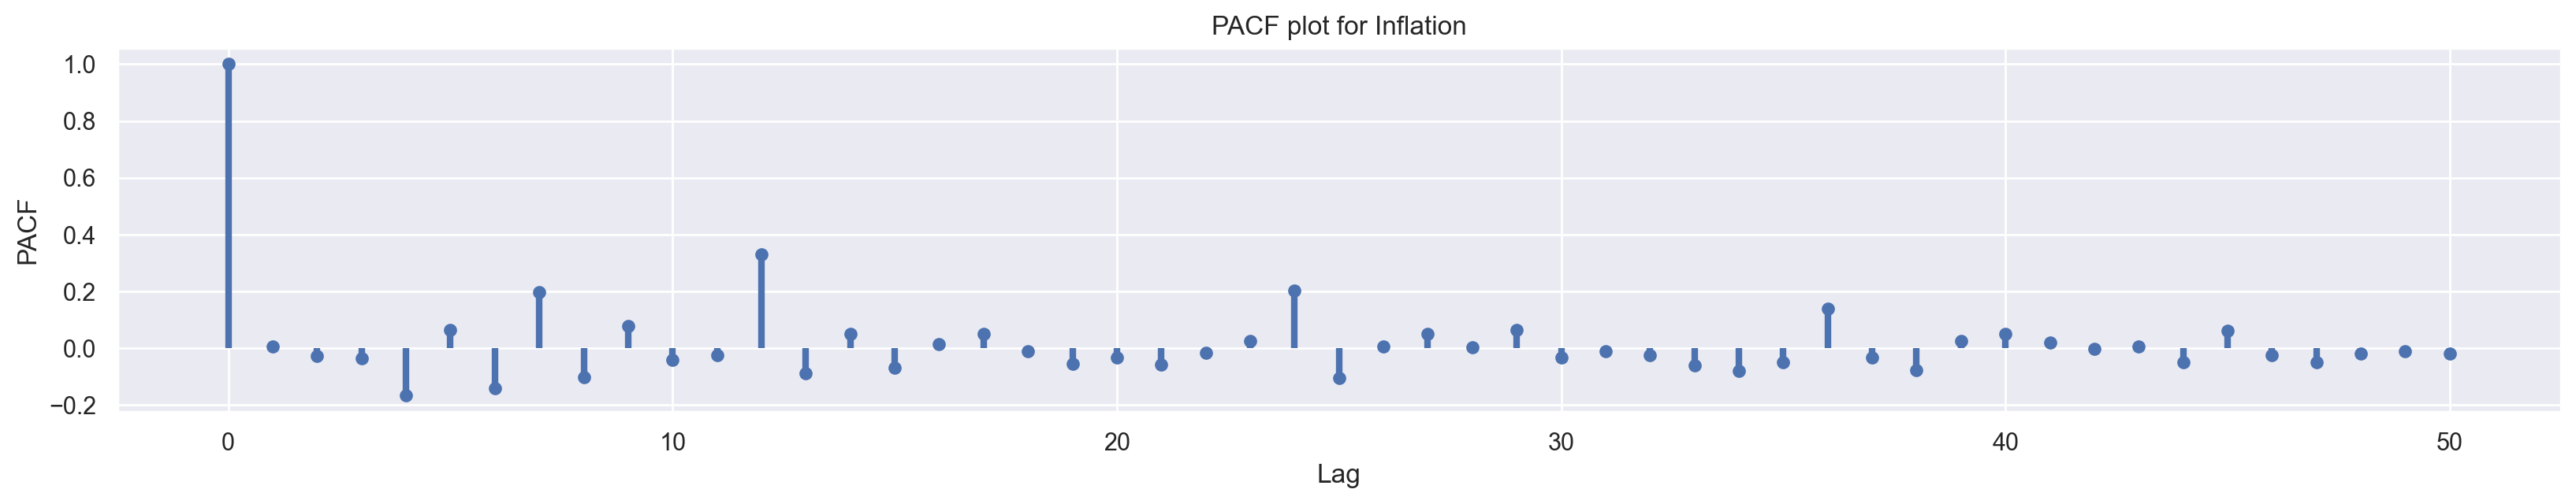

In [24]:
inflation__acf = plt__acf(df_red_transformed[["Inflation"]], 50)
inflation__pacf = plt__pacf(df_red_transformed[["Inflation"]], 50)

# This is where the fun begins

First we run the Kalman filter over the training data and optimize the negative log likelihood

In [32]:
y = np.array(df_red_transformed_train["Inflation"].tolist())
u = np.array(df_red_transformed_train.drop("Inflation", axis = 1))
theta0 = np.array([1,1,1,1])

def neg_log_likelihood(theta, y, u):
    gamma = theta[:-1]
    R = theta[-1]
    
    sigma = np.repeat(2 * R, len(y))
    epsilon = y - gamma @ u.T
    
    first_sum = 0
    for i in range(len(y)):
        first_sum += np.log(np.abs(sigma[i]))
    first_term = .5 * first_sum
    
    second_sum = 0
    for i in range(len(y)):
        second_sum += epsilon[i] * (1/sigma[i]) * epsilon[i]
    second_term = .5 * second_sum
    return first_term + second_term

error = 1
while error > .1:
    theta = minimize(neg_log_likelihood, theta0, args = (y,u), method = "BFGS").x
    error = np.sum(np.abs(theta - theta0))
    print(theta)
    theta0 = theta

print(theta)

[-1.82991103e+08 -4.70450587e+06 -2.24946539e+07 -9.99332257e+07]
[-2.16384848e+08 -4.70450587e+06 -2.24953399e+07 -9.99324492e+07]
[-2.20378820e+08 -4.70450587e+06 -2.24953399e+07 -9.59384774e+07]
[-2.20797518e+08 -4.70450587e+06 -2.24534992e+07 -9.58547959e+07]
[-2.20797518e+08 -4.70450587e+06 -2.24534992e+07 -9.58547959e+07]
[-2.20797518e+08 -4.70450587e+06 -2.24534992e+07 -9.58547959e+07]


In [34]:
np.array(df_red_transformed_train.drop("Inflation", axis = 1))

array([[-2.77767319e+01,  0.00000000e+00,  0.00000000e+00],
       [ 2.09435684e+01,  0.00000000e+00,  0.00000000e+00],
       [-8.52370690e+00,  6.29139073e+00, -8.60927152e+00],
       [-1.22393686e+01,  0.00000000e+00,  0.00000000e+00],
       [-2.24161074e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.37306055e-02, -9.34579439e-01, -3.91304348e+01],
       [-1.83328756e+01,  0.00000000e+00,  0.00000000e+00],
       [ 2.49201278e+01,  0.00000000e+00,  0.00000000e+00],
       [-7.53802665e+00, -2.83018868e+00,  6.54761905e+01],
       [-3.72688892e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.09209134e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.59505208e+00,  3.88349515e+00,  2.87769784e+00],
       [-4.24543416e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.64179354e+01,  0.00000000e+00,  0.00000000e+00],
       [ 8.78771837e+00,  8.09968847e+00, -1.95804196e+01],
       [ 1.20924574e+01,  0.00000000e+00,  0.00000000e+00],
       [ 6.50097677e+00,  0.00000000e+00

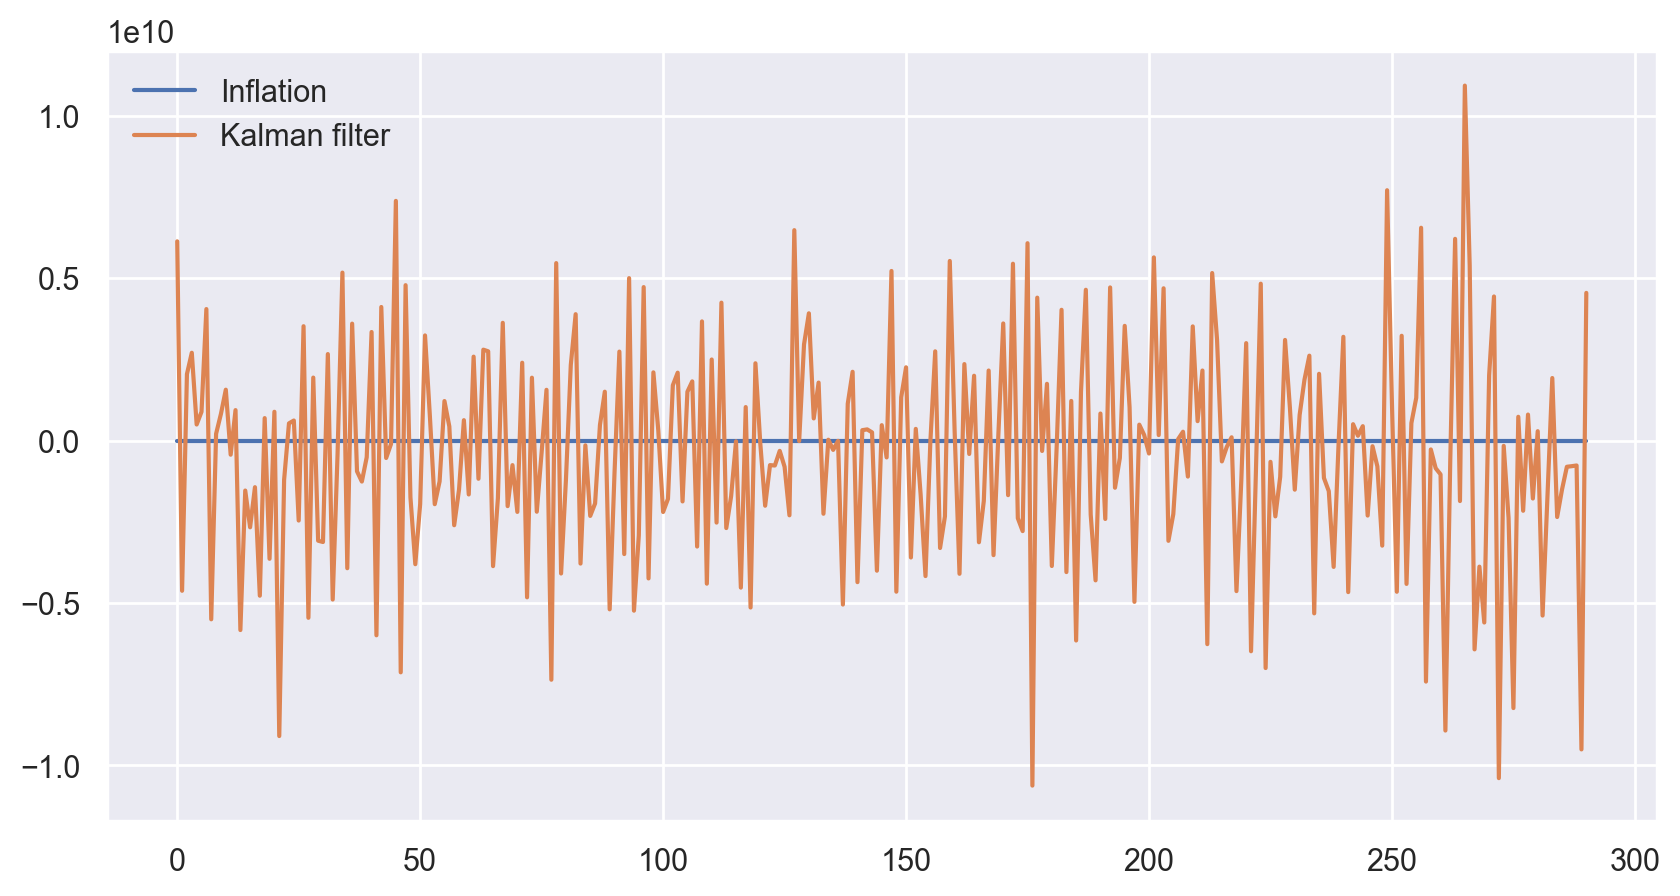

In [29]:
plt.plot(y, label = "Inflation")
plt.plot(theta[:-1] @ u.T, label = "Kalman filter")
plt.legend()
plt.show()